# Erosion Model via NN

In [25]:
# erosion model via NN
import matplotlib.pyplot as plt
import numpy as np
import random

# D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
D_in, H, D_out = 4, 5, 4  # 2 3 1

arr = np.empty((0, D_in), dtype='f')   
y = np.empty((0, D_out), dtype='f')

# Randomly initialize weights
w1 = np.random.randn(D_in, H)*0.05
w2 = np.random.randn(H, D_out)*0.05

b1 = np.zeros(H)  # bias
b2 = np.zeros(D_out)

mw1 = np.zeros_like(w1)
mw2 = np.zeros_like(w2)
mb1 = np.zeros_like(b1)
mb2 = np.zeros_like(b2)

learning_rate = 1e-1
n_runs = 50

# training set - 2x2 arrays clockwise
njumps = {
    (1,0,0,0): np.array((.7,.1,.1,.1)),
    (1,1,0,0): np.array((.7,.7,.3,.3)),
    (0,0,1,1): np.array((.3,.3,.7,.7)),
    (0,0,0,1): np.array((.1,.1,.1,.7)),
}

for key, value in njumps.items():
    for t in range(n_runs):
        arr = np.array(key)
        y = value
        # Forward pass: compute predicted y
        h = np.dot(arr, w1) + b1
        h_relu = np.maximum(h, 0)
        #h_relu = softmax(h)
        y_pred = np.dot(h_relu, w2) + b2 # output
        
        # Compute and print loss
        loss = np.square(y_pred - y).sum()
        if t == (n_runs-1):
            print(key, t, loss, y, y_pred)

        # Backprop to compute gradients of w1 and w2 with respect to loss
        grad_y_pred = (y_pred - y)
        grad_w2 = h_relu.dot(np.ones_like(w2)) * grad_y_pred * np.ones_like(w2)  # dw2 = (.) ReLu(h)
        grad_b2 = grad_y_pred
        grad_h_relu = np.dot(w2, grad_y_pred.T)  # dw1 = (.) w2 ReLu'(h) x
        grad_h = grad_h_relu.copy()
        grad_h[h < 0] = 0  # ReLU'
        grad_w1 = grad_h * np.array([arr]).T
        grad_b1 = np.dot(w2, grad_y_pred.T)

        # Update weights
        for param, dparam, mem in zip([w1, w2, b1, b2], [grad_w1, grad_w2, grad_b1.T[0], grad_b2[0]], [mw1, mw2, mb1, mb2]):
            mem += dparam * dparam
            param += -learning_rate * dparam / np.sqrt(mem + 1e-8)  # adagrad update

print(w1, w2)
# now apply this NN to 2x2 patches of the terrain to erode

(1, 0, 0, 0) 49 1.1251377533413163e-17 [0.7 0.1 0.1 0.1] [0.7 0.1 0.1 0.1]
(1, 1, 0, 0) 49 8.683383480770336e-15 [0.7 0.7 0.3 0.3] [0.69999994 0.69999995 0.29999996 0.29999996]
(0, 0, 1, 1) 49 1.5313655577059196e-11 [0.3 0.3 0.7 0.7] [0.29999897 0.29999921 0.69999741 0.69999737]
(0, 0, 0, 1) 49 9.633540899274761e-10 [0.1 0.1 0.1 0.7] [0.09999951 0.0999984  0.10003098 0.69999907]
[[ 0.32388161  0.19619431  0.27989118  0.04229476  0.18148717]
 [ 0.24633468 -0.12336127 -0.03735897 -0.15834469  0.06825519]
 [ 0.25280997 -0.01663841 -0.20818931  0.02088819  0.23919284]
 [ 0.18236358 -0.19326831 -0.35992767  0.10838621  0.14420587]] [[ 0.02031706  0.07968368  0.01458561  0.45548609]
 [ 0.0803883   0.01902601  0.01041253  0.31758191]
 [ 0.06638852  0.07696165  0.08055744  0.31182154]
 [ 0.00444533 -0.04723847 -0.04305427  0.349387  ]
 [ 0.05680049  0.06016681  0.12919569  0.40909879]]


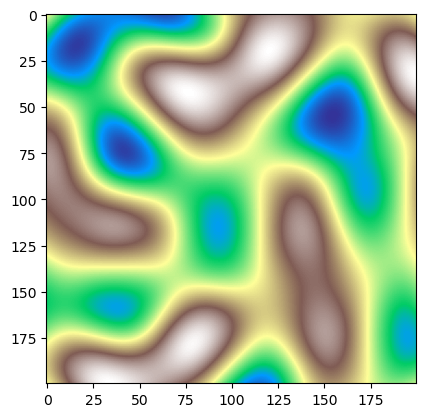

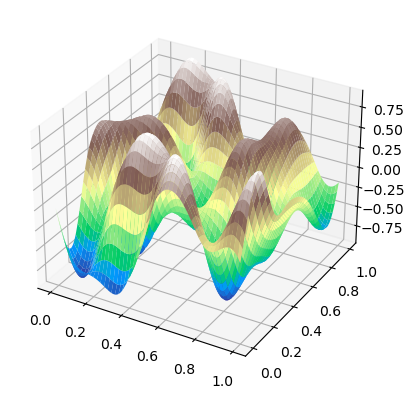

In [3]:
%matplotlib inline
#import noise
import numpy as np
import matplotlib
from mpl_toolkits.mplot3d import axes3d

"""Perlin noise -- pure python implementation"""

__version__ = '$Id: perlin.py 521 2008-12-15 03:03:52Z casey.duncan $'

from math import floor, fmod, sqrt
from random import randint

# 3D Gradient vectors
_GRAD3 = ((1,1,0),(-1,1,0),(1,-1,0),(-1,-1,0), 
	(1,0,1),(-1,0,1),(1,0,-1),(-1,0,-1), 
	(0,1,1),(0,-1,1),(0,1,-1),(0,-1,-1),
	(1,1,0),(0,-1,1),(-1,1,0),(0,-1,-1),
) 

# 4D Gradient vectors
_GRAD4 = ((0,1,1,1), (0,1,1,-1), (0,1,-1,1), (0,1,-1,-1), 
	(0,-1,1,1), (0,-1,1,-1), (0,-1,-1,1), (0,-1,-1,-1), 
	(1,0,1,1), (1,0,1,-1), (1,0,-1,1), (1,0,-1,-1), 
	(-1,0,1,1), (-1,0,1,-1), (-1,0,-1,1), (-1,0,-1,-1), 
	(1,1,0,1), (1,1,0,-1), (1,-1,0,1), (1,-1,0,-1), 
	(-1,1,0,1), (-1,1,0,-1), (-1,-1,0,1), (-1,-1,0,-1), 
	(1,1,1,0), (1,1,-1,0), (1,-1,1,0), (1,-1,-1,0), 
	(-1,1,1,0), (-1,1,-1,0), (-1,-1,1,0), (-1,-1,-1,0))

# A lookup table to traverse the simplex around a given point in 4D. 
# Details can be found where this table is used, in the 4D noise method. 
_SIMPLEX = (
	(0,1,2,3),(0,1,3,2),(0,0,0,0),(0,2,3,1),(0,0,0,0),(0,0,0,0),(0,0,0,0),(1,2,3,0), 
	(0,2,1,3),(0,0,0,0),(0,3,1,2),(0,3,2,1),(0,0,0,0),(0,0,0,0),(0,0,0,0),(1,3,2,0), 
	(0,0,0,0),(0,0,0,0),(0,0,0,0),(0,0,0,0),(0,0,0,0),(0,0,0,0),(0,0,0,0),(0,0,0,0), 
	(1,2,0,3),(0,0,0,0),(1,3,0,2),(0,0,0,0),(0,0,0,0),(0,0,0,0),(2,3,0,1),(2,3,1,0), 
	(1,0,2,3),(1,0,3,2),(0,0,0,0),(0,0,0,0),(0,0,0,0),(2,0,3,1),(0,0,0,0),(2,1,3,0), 
	(0,0,0,0),(0,0,0,0),(0,0,0,0),(0,0,0,0),(0,0,0,0),(0,0,0,0),(0,0,0,0),(0,0,0,0), 
	(2,0,1,3),(0,0,0,0),(0,0,0,0),(0,0,0,0),(3,0,1,2),(3,0,2,1),(0,0,0,0),(3,1,2,0), 
	(2,1,0,3),(0,0,0,0),(0,0,0,0),(0,0,0,0),(3,1,0,2),(0,0,0,0),(3,2,0,1),(3,2,1,0))

# Simplex skew constants
_F2 = 0.5 * (sqrt(3.0) - 1.0)
_G2 = (3.0 - sqrt(3.0)) / 6.0
_F3 = 1.0 / 3.0
_G3 = 1.0 / 6.0


class BaseNoise:
	"""Noise abstract base class"""

	permutation = (151,160,137,91,90,15, 
		131,13,201,95,96,53,194,233,7,225,140,36,103,30,69,142,8,99,37,240,21,10,23, 
		190,6,148,247,120,234,75,0,26,197,62,94,252,219,203,117,35,11,32,57,177,33, 
		88,237,149,56,87,174,20,125,136,171,168,68,175,74,165,71,134,139,48,27,166, 
		77,146,158,231,83,111,229,122,60,211,133,230,220,105,92,41,55,46,245,40,244, 
		102,143,54,65,25,63,161,1,216,80,73,209,76,132,187,208,89,18,169,200,196, 
		135,130,116,188,159,86,164,100,109,198,173,186,3,64,52,217,226,250,124,123, 
		5,202,38,147,118,126,255,82,85,212,207,206,59,227,47,16,58,17,182,189,28,42, 
		223,183,170,213,119,248,152,2,44,154,163,70,221,153,101,155,167,43,172,9, 
		129,22,39,253,9,98,108,110,79,113,224,232,178,185,112,104,218,246,97,228, 
		251,34,242,193,238,210,144,12,191,179,162,241, 81,51,145,235,249,14,239,107, 
		49,192,214,31,181,199,106,157,184,84,204,176,115,121,50,45,127,4,150,254, 
		138,236,205,93,222,114,67,29,24,72,243,141,128,195,78,66,215,61,156,180)
	
	period = len(permutation)

	# Double permutation array so we don't need to wrap
	permutation = permutation * 2

	def __init__(self, period=None, permutation_table=None):
		"""Initialize the noise generator. With no arguments, the default
		period and permutation table are used (256). The default permutation
		table generates the exact same noise pattern each time.
		
		An integer period can be specified, to generate a random permutation
		table with period elements. The period determines the (integer)
		interval that the noise repeats, which is useful for creating tiled
		textures.  period should be a power-of-two, though this is not
		enforced. Note that the speed of the noise algorithm is indpendent of
		the period size, though larger periods mean a larger table, which
		consume more memory.

		A permutation table consisting of an iterable sequence of whole
		numbers can be specified directly. This should have a power-of-two
		length. Typical permutation tables are a sequnce of unique integers in
		the range [0,period) in random order, though other arrangements could
		prove useful, they will not be "pure" simplex noise. The largest
		element in the sequence must be no larger than period-1.

		period and permutation_table may not be specified together.
		"""
		if period is not None and permutation_table is not None:
			raise ValueError(
				'Can specify either period or permutation_table, not both')
		if period is not None:
			self.randomize(period)
		elif permutation_table is not None:
			self.permutation = tuple(permutation_table) * 2
			self.period = len(permutation_table)

	def randomize(self, period=None):
		"""Randomize the permutation table used by the noise functions. This
		makes them generate a different noise pattern for the same inputs.
		"""
		if period is not None:
			self.period = period
		perm = list(range(self.period))
		perm_right = self.period - 1
		for i in list(perm):
			j = randint(0, perm_right)
			perm[i], perm[j] = perm[j], perm[i]
		self.permutation = tuple(perm) * 2


class SimplexNoise(BaseNoise):
	"""Perlin simplex noise generator

	Adapted from Stefan Gustavson's Java implementation described here:

	http://staffwww.itn.liu.se/~stegu/simplexnoise/simplexnoise.pdf

	To summarize:

	"In 2001, Ken Perlin presented 'simplex noise', a replacement for his classic
	noise algorithm.  Classic 'Perlin noise' won him an academy award and has
	become an ubiquitous procedural primitive for computer graphics over the
	years, but in hindsight it has quite a few limitations.  Ken Perlin himself
	designed simplex noise specifically to overcome those limitations, and he
	spent a lot of good thinking on it. Therefore, it is a better idea than his
	original algorithm. A few of the more prominent advantages are: 

	* Simplex noise has a lower computational complexity and requires fewer
	  multiplications. 
	* Simplex noise scales to higher dimensions (4D, 5D and up) with much less
	  computational cost, the complexity is O(N) for N dimensions instead of 
	  the O(2^N) of classic Noise. 
	* Simplex noise has no noticeable directional artifacts.  Simplex noise has 
	  a well-defined and continuous gradient everywhere that can be computed 
	  quite cheaply. 
	* Simplex noise is easy to implement in hardware."
	"""

	def noise2(self, x, y):
		"""2D Perlin simplex noise. 
		
		Return a floating point value from -1 to 1 for the given x, y coordinate. 
		The same value is always returned for a given x, y pair unless the
		permutation table changes (see randomize above). 
		"""
		# Skew input space to determine which simplex (triangle) we are in
		s = (x + y) * _F2
		i = floor(x + s)
		j = floor(y + s)
		t = (i + j) * _G2
		x0 = x - (i - t) # "Unskewed" distances from cell origin
		y0 = y - (j - t)

		if x0 > y0:
			i1 = 1; j1 = 0 # Lower triangle, XY order: (0,0)->(1,0)->(1,1)
		else:
			i1 = 0; j1 = 1 # Upper triangle, YX order: (0,0)->(0,1)->(1,1)
		
		x1 = x0 - i1 + _G2 # Offsets for middle corner in (x,y) unskewed coords
		y1 = y0 - j1 + _G2
		x2 = x0 + _G2 * 2.0 - 1.0 # Offsets for last corner in (x,y) unskewed coords
		y2 = y0 + _G2 * 2.0 - 1.0

		# Determine hashed gradient indices of the three simplex corners
		perm = self.permutation
		ii = int(i) % self.period
		jj = int(j) % self.period
		gi0 = perm[ii + perm[jj]] % 12
		gi1 = perm[ii + i1 + perm[jj + j1]] % 12
		gi2 = perm[ii + 1 + perm[jj + 1]] % 12

		# Calculate the contribution from the three corners
		tt = 0.5 - x0**2 - y0**2
		if tt > 0:
			g = _GRAD3[gi0]
			noise = tt**4 * (g[0] * x0 + g[1] * y0)
		else:
			noise = 0.0
		
		tt = 0.5 - x1**2 - y1**2
		if tt > 0:
			g = _GRAD3[gi1]
			noise += tt**4 * (g[0] * x1 + g[1] * y1)
		
		tt = 0.5 - x2**2 - y2**2
		if tt > 0:
			g = _GRAD3[gi2]
			noise += tt**4 * (g[0] * x2 + g[1] * y2)

		return noise * 70.0 # scale noise to [-1, 1]

	def noise3(self, x, y, z):
		"""3D Perlin simplex noise. 
		
		Return a floating point value from -1 to 1 for the given x, y, z coordinate. 
		The same value is always returned for a given x, y, z pair unless the
		permutation table changes (see randomize above).
		"""
		# Skew the input space to determine which simplex cell we're in
		s = (x + y + z) * _F3
		i = floor(x + s)
		j = floor(y + s)
		k = floor(z + s)
		t = (i + j + k) * _G3
		x0 = x - (i - t) # "Unskewed" distances from cell origin
		y0 = y - (j - t)
		z0 = z - (k - t)

		# For the 3D case, the simplex shape is a slightly irregular tetrahedron. 
		# Determine which simplex we are in. 
		if x0 >= y0:
			if y0 >= z0:
				i1 = 1; j1 = 0; k1 = 0
				i2 = 1; j2 = 1; k2 = 0
			elif x0 >= z0:
				i1 = 1; j1 = 0; k1 = 0
				i2 = 1; j2 = 0; k2 = 1
			else:
				i1 = 0; j1 = 0; k1 = 1
				i2 = 1; j2 = 0; k2 = 1
		else: # x0 < y0
			if y0 < z0:
				i1 = 0; j1 = 0; k1 = 1
				i2 = 0; j2 = 1; k2 = 1
			elif x0 < z0:
				i1 = 0; j1 = 1; k1 = 0
				i2 = 0; j2 = 1; k2 = 1
			else:
				i1 = 0; j1 = 1; k1 = 0
				i2 = 1; j2 = 1; k2 = 0
		
		# Offsets for remaining corners
		x1 = x0 - i1 + _G3
		y1 = y0 - j1 + _G3
		z1 = z0 - k1 + _G3
		x2 = x0 - i2 + 2.0 * _G3
		y2 = y0 - j2 + 2.0 * _G3
		z2 = z0 - k2 + 2.0 * _G3
		x3 = x0 - 1.0 + 3.0 * _G3
		y3 = y0 - 1.0 + 3.0 * _G3
		z3 = z0 - 1.0 + 3.0 * _G3

		# Calculate the hashed gradient indices of the four simplex corners
		perm = self.permutation
		ii = int(i) % self.period
		jj = int(j) % self.period
		kk = int(k) % self.period
		gi0 = perm[ii + perm[jj + perm[kk]]] % 12
		gi1 = perm[ii + i1 + perm[jj + j1 + perm[kk + k1]]] % 12
		gi2 = perm[ii + i2 + perm[jj + j2 + perm[kk + k2]]] % 12
		gi3 = perm[ii + 1 + perm[jj + 1 + perm[kk + 1]]] % 12

		# Calculate the contribution from the four corners
		noise = 0.0
		tt = 0.6 - x0**2 - y0**2 - z0**2
		if tt > 0:
			g = _GRAD3[gi0]
			noise = tt**4 * (g[0] * x0 + g[1] * y0 + g[2] * z0)
		else:
			noise = 0.0
		
		tt = 0.6 - x1**2 - y1**2 - z1**2
		if tt > 0:
			g = _GRAD3[gi1]
			noise += tt**4 * (g[0] * x1 + g[1] * y1 + g[2] * z1)
		
		tt = 0.6 - x2**2 - y2**2 - z2**2
		if tt > 0:
			g = _GRAD3[gi2]
			noise += tt**4 * (g[0] * x2 + g[1] * y2 + g[2] * z2)
		
		tt = 0.6 - x3**2 - y3**2 - z3**2
		if tt > 0:
			g = _GRAD3[gi3]
			noise += tt**4 * (g[0] * x3 + g[1] * y3 + g[2] * z3)
		
		return noise * 32.0


def lerp(t, a, b):
	return a + t * (b - a)

def grad3(hash, x, y, z):
	g = _GRAD3[hash % 16]
	return x*g[0] + y*g[1] + z*g[2]


class TileableNoise(BaseNoise):
	"""Tileable implemention of Perlin "improved" noise. This
	is based on the reference implementation published here:
	
	http://mrl.nyu.edu/~perlin/noise/
	"""

	def noise3(self, x, y, z, repeat, base=0.0):
		"""Tileable 3D noise.
		
		repeat specifies the integer interval in each dimension 
		when the noise pattern repeats.
		
		base allows a different texture to be generated for
		the same repeat interval.
		"""
		i = int(fmod(floor(x), repeat))
		j = int(fmod(floor(y), repeat))
		k = int(fmod(floor(z), repeat))
		ii = (i + 1) % repeat
		jj = (j + 1) % repeat
		kk = (k + 1) % repeat
		if base:
			i += base; j += base; k += base
			ii += base; jj += base; kk += base

		x -= floor(x); y -= floor(y); z -= floor(z)
		fx = x**3 * (x * (x * 6 - 15) + 10)
		fy = y**3 * (y * (y * 6 - 15) + 10)
		fz = z**3 * (z * (z * 6 - 15) + 10)

		perm = self.permutation
		A = perm[i]
		AA = perm[A + j]
		AB = perm[A + jj]
		B = perm[ii]
		BA = perm[B + j]
		BB = perm[B + jj]
		
		return lerp(fz, lerp(fy, lerp(fx, grad3(perm[AA + k], x, y, z),
										  grad3(perm[BA + k], x - 1, y, z)),
								 lerp(fx, grad3(perm[AB + k], x, y - 1, z),
										  grad3(perm[BB + k], x - 1, y - 1, z))),
						lerp(fy, lerp(fx, grad3(perm[AA + kk], x, y, z - 1),
										  grad3(perm[BA + kk], x - 1, y, z - 1)),
								 lerp(fx, grad3(perm[AB + kk], x, y - 1, z - 1),
										  grad3(perm[BB + kk], x - 1, y - 1, z - 1))))

shape = (200, 200)
scale = 100.0
octaves = 6
persistence = 0.5
lacunarity = 2.0

world = np.zeros(shape)
bn = SimplexNoise()
bn.randomize()

for i in range(shape[0]):
    for j in range(shape[1]):
        world[i][j] = bn.noise2(i/scale, 
                                    j/scale, 
                                    #octaves=octaves, 
                                    #persistence=persistence, 
                                    #lacunarity=lacunarity, 
                                    #repeatx=1024, 
                                    #repeaty=1024, 
                                    #base=42)
                               )
        
matplotlib.pyplot.imshow(world, cmap='terrain')

lin_x = np.linspace(0,1,shape[0],endpoint=False)
lin_y = np.linspace(0,1,shape[1],endpoint=False)
x,y = np.meshgrid(lin_x,lin_y)
fig = matplotlib.pyplot.figure()
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(x,y,world,cmap='terrain')

## what are the atomic erosion elements I need to train on?

training: 
1. get a set of erosion features: pre-erosion -> post erosion
2. train a simlpe NN on it (simple 1-layer likely enough?)
3. test and validate


application:
1. create a simple random noise terrain
2. apply trained NN transformations



In [26]:
print(w1, w2)
# now apply this NN to 2x2 patches of the terrain to erode

for key, value in njumps.items():
    for t in range(n_runs):
        arr = np.array(key)
        y = value
        # Forward pass: compute predicted y
        h = np.dot(arr, w1) + b1
        h_relu = np.maximum(h, 0)
        #h_relu = softmax(h)
        y_pred = np.dot(h_relu, w2) + b2 # output

[[ 0.32388161  0.19619431  0.27989118  0.04229476  0.18148717]
 [ 0.24633468 -0.12336127 -0.03735897 -0.15834469  0.06825519]
 [ 0.25280997 -0.01663841 -0.20818931  0.02088819  0.23919284]
 [ 0.18236358 -0.19326831 -0.35992767  0.10838621  0.14420587]] [[ 0.02031706  0.07968368  0.01458561  0.45548609]
 [ 0.0803883   0.01902601  0.01041253  0.31758191]
 [ 0.06638852  0.07696165  0.08055744  0.31182154]
 [ 0.00444533 -0.04723847 -0.04305427  0.349387  ]
 [ 0.05680049  0.06016681  0.12919569  0.40909879]]


## sthg I need for my kids

In [1]:
# Rakki maths 2nd test
import random
import math

def sample_div(n=3, m=2):
    a = random.randint(10**(n-1), 10**n)
    b = random.randint(10**(m-1), 10**m) - 1
    b = max(2, b)
    return (a, b, a//b, a % b)

def sample_mult(n=3, m=1):
    a = random.randint(10**(n-1), 10**n)
    b = random.randint(10**(m-1), 10**m)
    return (a, b, a*b)

def sample_payback(n=4, m=3):
    a = random.randint(10**(n-1), 10**n)
    b = random.randint(10**(m-1), 10**m)
    while a < b:
        b = random.randint(10**(m-1), 10**m)
    c = random.randint(2, 10)
    return 'Ein Fahrrad kostet ' + str(a) + ' EUR, Aurelia zahlt ' + str(b) + ' an. Wie viel muss Aurelia in ' + str(c) + ' Raten zahlen?'

def write_number(n=4):
    a = random.randint(10**(n-1), 10**n)
    lttrs = ['T', 'H', 'Z', 'E']
    res = [c + lttrs[i + (len(lttrs)-n)] for i,c in enumerate(str(a))]
    random.shuffle(res)
    return res

def conv_nr(n=2):
    a = random.randint(10**(n-1), 10**n)
    return 'Wie viele mm sind ' + str(a) + ' m?'

def round_number(n=4):
    a = random.randint(10**(n-1), 10**n)
    return ('Runde ' + str(a) + ' auf Zehner, Hunderter und Tausender' + str(), int(round(a/1000, 2)*1000), int(round(a/1000, 1)*1000), int(round(a/1000, 0)*1000))


for i in range(2):
    problem = sample_div()
    print(f"{problem[0]} : {problem[1]} = {problem[2]}, R {problem[3]}")
for i in range(3):
    problem = sample_mult()
    print(f"{problem[0]} * {problem[1]} = {problem[2]}")
for i in range(2): 
    print(f"{sample_payback()}")
for i in range(2):
    print(f"{write_number()}")
for i in range(2):
    print(f"{conv_nr()}")
for i in range(3):  
    print(round_number())

712 : 49 = 14, R 26
699 : 20 = 34, R 19
932 * 2 = 1864
195 * 8 = 1560
322 * 9 = 2898
Ein Fahrrad kostet 5163 EUR, Aurelia zahlt 201 an. Wie viel muss Aurelia in 2 Raten zahlen?
Ein Fahrrad kostet 9257 EUR, Aurelia zahlt 317 an. Wie viel muss Aurelia in 2 Raten zahlen?
['9E', '2T', '4Z', '8H']
['4H', '7E', '7Z', '7T']
Wie viele mm sind 11 m?
Wie viele mm sind 52 m?
('Runde 1739 auf Zehner, Hunderter und Tausender', 1740, 1700, 2000)
('Runde 1615 auf Zehner, Hunderter und Tausender', 1610, 1600, 2000)
('Runde 6182 auf Zehner, Hunderter und Tausender', 6180, 6200, 6000)


## visualize memory formation from the ground up in time-dependent NNs

[0.65904607 0.65904607 0.65904607 0.65904607 0.81343406 0.81343406
 0.81343406 0.83925402 0.83925402 0.83925402]
[1. 1. 0. 1. 1. 0. 0. 0. 1. 0.]
0.5643856117639975
0.6643856045505228
0.5906890509046818


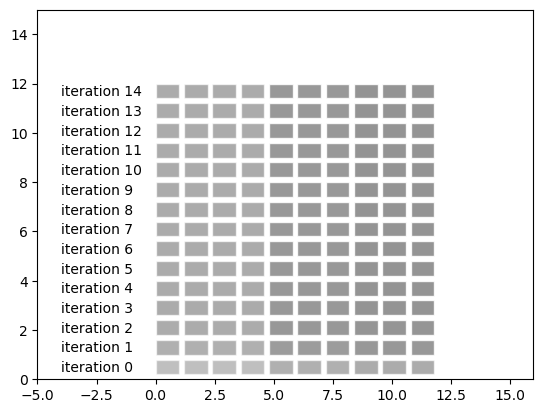

In [11]:
# test forget gate visualization xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
# what to do next here ? 2 dim ????
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def entropy(p):
    eps = 0.000000001  # for the 0-case
    return -p.dot(np.log2(p + eps))

eta = 0.001
x_arr = np.array([1., 1., 0., 1., 1., 0., 0., 0., 1., 0.])  # truth
x_arr_c = np.zeros_like(x_arr)  # what we try
wix = 1.
wxx = 1.
niter = 15
x_arr_hist = np.zeros((niter, len(x_arr)))
memory_lag = 3

for k in range(niter):
    for i, xt in enumerate(x_arr_c):
        if i>memory_lag:
            xt1 = sigmoid(xt*wix + x_arr_c[i - memory_lag]*wxx)
        else:
            xt1 = sigmoid(xt*wix)
        x_arr_hist[k][i] = xt1
        x_arr_c[i] = xt1
        err = x_arr_c[i] - xt1
        xt1 *= (1. - xt1)  # reuse as differential of sigmoid sig' = (1-sig)*sig
        wix -= eta * err * xt1 * xt
        wxx -= eta * err * xt1 * x_arr[i-memory_lag]
       
        
fig = plt.figure()
plt.xlim(-5, int(niter*1.1))
plt.ylim(0, niter)

someX, someY = 1, 0.6
currentAxis = plt.gca()
#currentAxis.add_patch(Rectangle((someX - .5, someY - .5), 4, 6, facecolor="none", ec='k'))
for j, xh in enumerate(x_arr_hist):
    currentAxis.annotate('iteration ' + str(j), xy=(-4, (someY+0.2)*j + 0.3))
    for i, xt in enumerate(xh):
        currentAxis.add_patch(Rectangle((someX*i + 0.2*i, (someY+0.2)*j + 0.2), someX, someY, facecolor="grey", ec='white', alpha = xt))

print(x_arr_c)
print(x_arr)

# how much info can I capture in 2 single-number weights? How much info is in the data?
# https://math.stackexchange.com/questions/1573537/entropy-of-a-character-in-a-string
print(entropy(np.array(x_arr/x_arr.sum()/x_arr.shape)))
x_arr = np.array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
print(entropy(np.array(x_arr/x_arr.sum()/x_arr.shape)))
x_arr = np.array([0., 1., 0., 1., 1., 1., 0., 1., 0., 1.])
print(entropy(np.array(x_arr/x_arr.sum()/x_arr.shape)))

In [3]:
# simplest case memory
import numpy as np
import random

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
D_in, H, D_out = 1, 1, 1  # 2

arr = np.empty((0, D_in), dtype='f')   
y = np.empty((0, D_out), dtype='f')

# Randomly initialize weights
w1 = np.random.randn(D_in, H)*0.05  # input to hidden
w2 = np.random.randn(H, D_out)*0.05  # memory: hidden to hidden

b1 = np.zeros(H)  # bias
b2 = np.zeros(D_out)

mw1 = np.zeros_like(w1)
mw2 = np.zeros_like(w2)
mb1 = np.zeros_like(b1)
mb2 = np.zeros_like(b2)

learning_rate = 1e-1
n_runs = 10

for key, value in njumps.items():
    for t in range(n_runs):
        arr = key
        y = value
        # Forward pass: compute predicted y
        h = np.dot(arr, w1) + b1
        h_relu = np.maximum(h, 0)
        #h_relu = softmax(h)
        y_pred = np.dot(h_relu, w2) + b2 # output

        # Compute and print loss
        loss = np.square(y_pred - y).sum()
        if t == (n_runs-1):
            print(key, t, loss, y, y_pred)

        # Backprop to compute gradients of w1 and w2 with respect to loss
        grad_y_pred = (y_pred - y)
        grad_w2 = np.dot(h_relu.T, grad_y_pred) * np.ones_like(w2)  # dw2 = (.) ReLu(h)
        grad_b2 = grad_y_pred
        grad_h_relu = np.dot(grad_y_pred, w2.T)  # dw1 = (.) w2 ReLu'(h) x
        grad_h = grad_h_relu.copy()
        grad_h[h < 0] = 0  # ReLU'
        grad_w1 = np.dot(grad_h.T, arr)
        grad_b1 = np.dot(w2, grad_y_pred.T)

        # Update weights
        for param, dparam, mem in zip([w1, w2, b1, b2], [grad_w1.T, grad_w2, grad_b1.T[0], grad_b2[0]], [mw1, mw2, mb1, mb2]):
            mem += dparam * dparam
            param += -learning_rate * dparam / np.sqrt(mem + 1e-8)  # adagrad update

print(w1, w2)

NameError: name 'njumps' is not defined

In [2]:
# simple short term memory recurrence
import numpy as np
import random

# D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
D_in, H, D_out = 1, 5, 1  # 2

arr = np.empty((0, D_in), dtype='f')   
y = np.empty((0, D_out), dtype='f')

# Randomly initialize weights
w1 = np.random.randn(D_in, H)*0.05
w2 = np.random.randn(H, D_out)*0.05

b1 = np.zeros(H)  # bias
b2 = np.zeros(D_out)

mw1 = np.zeros_like(w1)
mw2 = np.zeros_like(w2)
mb1 = np.zeros_like(b1)
mb2 = np.zeros_like(b2)

learning_rate = 1e-1
n_runs = 10

for key, value in njumps.items():
    for t in range(n_runs):
        arr = key
        y = value
        # Forward pass: compute predicted y
        h = np.dot(arr, w1) + b1
        h_relu = np.maximum(h, 0)
        #h_relu = softmax(h)
        y_pred = np.dot(h_relu, w2) + b2 # output

        # Compute and print loss
        loss = np.square(y_pred - y).sum()
        if t == (n_runs-1):
            print(key, t, loss, y, y_pred)

        # Backprop to compute gradients of w1 and w2 with respect to loss
        grad_y_pred = (y_pred - y)
        grad_w2 = np.dot(h_relu.T, grad_y_pred) * np.ones_like(w2)  # dw2 = (.) ReLu(h)
        grad_b2 = grad_y_pred
        grad_h_relu = np.dot(grad_y_pred, w2.T)  # dw1 = (.) w2 ReLu'(h) x
        grad_h = grad_h_relu.copy()
        grad_h[h < 0] = 0  # ReLU'
        grad_w1 = np.dot(grad_h.T, arr)
        grad_b1 = np.dot(w2, grad_y_pred.T)

        # Update weights
        for param, dparam, mem in zip([w1, w2, b1, b2], [grad_w1.T, grad_w2, grad_b1.T[0], grad_b2[0]], [mw1, mw2, mb1, mb2]):
            mem += dparam * dparam
            param += -learning_rate * dparam / np.sqrt(mem + 1e-8)  # adagrad update

print(w1, w2)


NameError: name 'njumps' is not defined

In [77]:
# set S = {(a, b, c, d) | a, b, c, and d are all integers with 0 <= a, b, c, d <= 10,000,000}.
# Let M be the maximum value f obtains on S. Find (a, b, c, d) in S with minimum sum (a+b+c+d) where f(a, b, c, d) = M.
import math
import itertools

def combination(n, r): # n choose k
    return int((math.factorial(n)) / ((math.factorial(r)) * math.factorial(n - r)))

def pascals_triangle(rows):
    result = [] # need something to collect our results in
    for count in range(rows): # start at 0, up to but not including rows number.
        row = [] # need a row element to collect the row in
        for element in range(count + 1): 
            row.append(combination(count, element))
        result.append(row)
    return result

def min_corners(current_corners):
    '''get index of minimum value and larger neighbour value'''
    midx = current_corners.index(min(current_corners))
    if midx > 0:
        if midx < len(current_corners)-1:
            if current_corners[midx-1] < current_corners[midx+1]:
                return (midx, midx+1)
            return (midx, midx-1)
        if current_corners[midx-1] < current_corners[0]:
            return (midx, 0)
        return (midx, midx-1)
    if current_corners[-1] < current_corners[midx+1]:
        return (midx, midx+1)
    return (midx, len(current_corners)-1)

def rotate(l, n):
    return l[n:] + l[:n]

def next_corners(current_corners=[1, 1, 1, 1]):
    a = int(sum(current_corners) / 4)
    rot_idx = min_corners(current_corners)[0] + 1
    current_corners = rotate(current_corners, rot_idx)
    res = [a, a+current_corners[0], a+current_corners[0]-current_corners[1], 
            a+current_corners[3]]
    return rotate(res, -rot_idx)

# start with a in the middle, +/- steps left and right
corners = [2, 4, 2, 4]
all_signs = set()
for lcomb in itertools.combinations_with_replacement([-1,1], 4):
    for lperm in list(itertools.permutations(lcomb, 4)):
        all_signs.add(lperm)

# set signs so that both sides are equal (and minimal)
max_total = 10000000000
max_idx = -1
for idx, signs in enumerate(all_signs):
    sum_left = sum([corners[i]*signs[i] for i in range(int(len(corners)/2))])
    sum_right = sum([corners[i]*signs[i] for i in range(int(len(corners)/2), len(corners))])
    if sum_left == sum_right and sum_left < max_total and sum_left > 0:
        print(idx, sum_left, sum_right)
        max_total = sum_left
        max_idx = idx

# set a so that sum = 0
list_all_signs = list(all_signs)
corners = [el*list_all_signs[max_idx][i] for i, el in enumerate(corners)]
sum_a = sum(corners)
if min(corners) < 0:
    sum_a += min(corners)
print(sum_a, corners)
run_total = -sum_a
for idx, el in enumerate(corners):
    print(run_total)
    run_total += el
print(run_total)

11 2 2
2 [-2, 4, -2, 4]
-2
-4
0
-2
2


In [5]:
# set S = {(a, b, c, d) | a, b, c, and d are all integers with 0 <= a, b, c, d <= 10,000,000}.
# Let M be the maximum value f obtains on S. Find (a, b, c, d) in S with minimum sum (a+b+c+d) where f(a, b, c, d) = M.
import math
import itertools

# start with a in the middle, +/- steps left and right
corners = [2, 4, 2, 4]
all_signs = set()
for lcomb in itertools.combinations_with_replacement([-1,1], 4):
    for lperm in list(itertools.permutations(lcomb, 4)):
        all_signs.add(lperm)

for i in range(5):        
    # set signs so that both sides are equal (and minimal)
    max_total = 0
    max_idx = -1
    for idx, signs in enumerate(all_signs):
        sum_left = sum([corners[i]*signs[i] for i in range(int(len(corners)/2))])
        sum_right = sum([corners[i]*signs[i] for i in range(int(len(corners)/2), len(corners))])
        if sum_left == sum_right and sum_left > max_total:
            max_total = sum_left
            max_idx = idx

    # set a so that sum = 0
    list_all_signs = list(all_signs)
    corners = [el*list_all_signs[max_idx][i] for i, el in enumerate(corners)]
    sum_a = sum(corners)
    if min(corners) < 0:
        sum_a += min(corners)
    #print(sum_a, corners)
    run_total = -sum_a
    new_corners = []
    for idx, el in enumerate(corners):
        #print(run_total)
        new_corners.append(run_total)
        run_total += el
    #print(run_total)
    print(new_corners)
    corners = [e for e in new_corners]

[-12, -10, -6, -4]
[6, 18, 8, 14]
[12, 18, 36, 28]
[70, 82, 100, 64]
[112, 182, 264, 164]


In [11]:

import smtplib

EMAIL_BACKEND = 'django.core.mail.backends.smtp.EmailBackend'
DEFAULT_FROM_EMAIL = "site_admin@xxx.com"
EMAIL_HOST = "smtp.world4you.com"
EMAIL_HOST_USER = "site_admin@xxx.com"
EMAIL_HOST_PASSWORD = "sdsdfsdf3s-"
EMAIL_PORT = 587
EMAIL_USE_TLS = True
EMAIL_USE_SSL = False

sent_from = EMAIL_HOST_USER
to = ['xxx@yahoo.com']
subject = 'Lorem ipsum dolor sit amet'
body = 'consectetur adipiscing elit'

email_text = """\
From: %s
To: %s
Subject: %s

%s
""" % (sent_from, ", ".join(to), subject, body)

try:
    #smtp_server = smtplib.SMTP_SSL(EMAIL_HOST, EMAIL_PORT)
    smtp_server = smtplib.SMTP(EMAIL_HOST, EMAIL_PORT)
    smtp_server.ehlo()
    smtp_server.login(EMAIL_HOST_USER, EMAIL_HOST_PASSWORD)
    smtp_server.sendmail(sent_from, to, email_text)
    smtp_server.close()
    print ("Email sent successfully!")
except Exception as ex:
    print ("Something went wrong….", ex)

Email sent successfully!


In [27]:
# find a sequence in pi
import sys

def calcPi():
    q, r, t, k, n, l = 1, 0, 1, 1, 3, 3
    while True:
        if 4*q+r-t < n*t:
            yield n
            nr = 10*(r-n*t)
            n  = ((10*(3*q+r))//t)-10*n
            q  *= 10
            r  = nr
        else:
            nr = (2*q+r)*l
            nn = (q*(7*k)+2+(r*l))//(t*l)
            q  *= k
            t  *= l
            l  += 2
            k += 1
            n  = nn
            r  = nr

searchstr = input("enter searchstr: ")
nsearch = ''
for c in searchstr:
    nsearch += str(ord(c) - 97)
print(nsearch)
            
pi_digits = calcPi()
i = 0
currentstr = ""
ndigits = 100000
for d in pi_digits:
    #sys.stdout.write(str(d))
    if i > len(nsearch)-1:
        if currentstr == nsearch:
            print(f"found at position: {i}")
            break
        currentstr = currentstr[1:] + str(d)
    else:
        currentstr += str(d)
    i += 1
    #if i == 40:  print(""); i = 0; nd += 40
    if i > ndigits:
        print(f"not found in the first {ndigits} digits")
        break

enter searchstr: meia
12480
found at position: 42529


In [20]:
# illustrate decision boundary
import numpy as np
import random

# D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
D_in, H, D_out = 2, 3, 1  # 2 3 1

arr = np.empty((0, D_in), dtype='f')   
y = np.empty((0, D_out), dtype='f')

# Randomly initialize weights
w1 = np.random.randn(D_in, H)*0.05
w2 = np.random.randn(H, D_out)*0.05

b1 = np.zeros(H)  # bias
b2 = np.zeros(D_out)

mw1 = np.zeros_like(w1)
mw2 = np.zeros_like(w2)
mb1 = np.zeros_like(b1)
mb2 = np.zeros_like(b2)

learning_rate = 1e-1
n_runs = 20

njumps = {
    (2, 1): np.array((0)),
    (-1,3): np.array((1))
}

for key, value in njumps.items():
    for t in range(n_runs):
        arr = np.array(key)
        y = value
        # Forward pass: compute predicted y
        h = np.dot(arr, w1) + b1
        h_relu = np.maximum(h, 0)
        #h_relu = softmax(h)
        y_pred = np.dot(h_relu, w2) + b2 # output

        # Compute and print loss
        loss = np.square(y_pred - y).sum()
        if t == (n_runs-1):
            print(key, t, loss, y, y_pred)

        # Backprop to compute gradients of w1 and w2 with respect to loss
        grad_y_pred = (y_pred - y)
        grad_w2 = (h_relu * grad_y_pred).reshape((H, D_out))  # dw2 = (.) ReLu(h)
        grad_b2 = grad_y_pred
        grad_h_relu = np.dot(w2, grad_y_pred.T)  # dw1 = (.) w2 ReLu'(h) x
        grad_h = grad_h_relu.copy()
        grad_h[h < 0] = 0  # ReLU'
        grad_w1 = grad_h * np.array([arr]).T
        grad_b1 = np.dot(w2, grad_y_pred.T)

        # Update weights
        for param, dparam, mem in zip([w1, w2, b1, b2], [grad_w1, grad_w2, grad_b1.T[0], grad_b2[0]], [mw1, mw2, mb1, mb2]):
            mem += dparam * dparam
            param += -learning_rate * dparam / np.sqrt(mem + 1e-8)  # adagrad update

#print(w1, w2)

(2, 1) 19 3.009265538105056e-36 0 [1.73472348e-18]
(-1, 3) 19 4.5236276190435487e-13 1 [1.00000067]


(2, 1) 49 6.940892438410783e-185 0 [-8.33120186e-93]
(-1, 3) 49 1.3434498431140136e-26 1 [1.]
(2, 2) 49 0.00023784675783776094 0 [0.01542228]
(-2, 0) 49 1.232595164407831e-32 1 [1.]


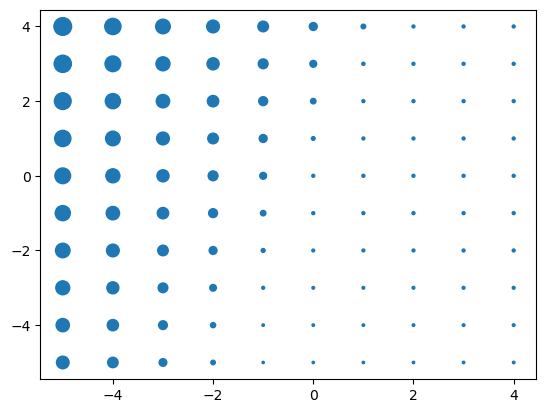

In [30]:
# illustrate decision boundary
import matplotlib.pyplot as plt
import numpy as np
import random

# D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
D_in, H, D_out = 2, 3, 1  # 2 3 1

arr = np.empty((0, D_in), dtype='f')   
y = np.empty((0, D_out), dtype='f')

# Randomly initialize weights
w1 = np.random.randn(D_in, H)*0.05
w2 = np.random.randn(H, D_out)*0.05

b1 = np.zeros(H)  # bias
b2 = np.zeros(D_out)

mw1 = np.zeros_like(w1)
mw2 = np.zeros_like(w2)
mb1 = np.zeros_like(b1)
mb2 = np.zeros_like(b2)

learning_rate = 1e-1
n_runs = 50

# training set
njumps = {
    (2, 1): np.array((0)),
    (-1,3): np.array((1)),
    (2, 2): np.array((0)),
    (-2,0): np.array((1))
}

for key, value in njumps.items():
    for t in range(n_runs):
        arr = np.array(key)
        y = value
        # Forward pass: compute predicted y
        h = np.dot(arr, w1) + b1
        h_relu = np.maximum(h, 0)
        #h_relu = softmax(h)
        y_pred = np.dot(h_relu, w2) + b2 # output

        # Compute and print loss
        loss = np.square(y_pred - y).sum()
        if t == (n_runs-1):
            print(key, t, loss, y, y_pred)

        # Backprop to compute gradients of w1 and w2 with respect to loss
        grad_y_pred = (y_pred - y)
        grad_w2 = (h_relu * grad_y_pred).reshape((H, D_out))  # dw2 = (.) ReLu(h)
        grad_b2 = grad_y_pred
        grad_h_relu = np.dot(w2, grad_y_pred.T)  # dw1 = (.) w2 ReLu'(h) x
        grad_h = grad_h_relu.copy()
        grad_h[h < 0] = 0  # ReLU'
        grad_w1 = grad_h * np.array([arr]).T
        grad_b1 = np.dot(w2, grad_y_pred.T)

        # Update weights
        for param, dparam, mem in zip([w1, w2, b1, b2], [grad_w1, grad_w2, grad_b1.T[0], grad_b2[0]], [mw1, mw2, mb1, mb2]):
            mem += dparam * dparam
            param += -learning_rate * dparam / np.sqrt(mem + 1e-8)  # adagrad update

#print(w1, w2)

plot_x = []
plot_y = []
plot_s = []
for xc in range(-5, 5):
    for yc in range(-5, 5):
        arr = np.array((xc, yc))
        y = np.array((1))
        if yc < 2*xc+1:  # separation line
            y = np.array((0))
        # Forward pass: compute predicted y
        h = np.dot(arr, w1) + b1
        h_relu = np.maximum(h, 0)
        #h_relu = softmax(h)
        y_pred = np.dot(h_relu, w2) + b2 # output
        plot_x.append(xc)
        plot_y.append(yc)
        plot_s.append(y_pred*50)

plt.scatter(plot_x, plot_y, plot_s)
plt.show()

In [1]:
# Diffie-Hellman

a = 5
b = 7
g = 13
n = 17

print((g**a) % n, (g**b) % n, (g**(a*b)) % n)

13 4 4
